# COSC 6373 - HW2-ICA - Minh Nguyen #2069407

In [77]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report


In [78]:
# Define dataset paths
train_dir = "train"
test_dir = "test"

# Define parameters
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

# Load training and validation data
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    subset="training",
    seed=42
)

val_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    subset="validation",
    seed=42
)

# Load test dataset
test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 360 files belonging to 2 classes.
Using 324 files for training.
Found 360 files belonging to 2 classes.
Using 36 files for validation.
Found 40 files belonging to 2 classes.


In [79]:
# Apply ResNet50 preprocessing
train_data = train_data.map(lambda x, y: (preprocess_input(x), y))
val_data = val_data.map(lambda x, y: (preprocess_input(x), y))

# Load ResNet50 as the base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # Freeze base model initially

In [80]:
# Add custom layers on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

In [81]:
# # Compile model
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# # Train initial model
# history = model.fit(train_data, validation_data=val_data, epochs=5)

In [82]:
# Unfreeze some layers for fine-tuning
base_model.trainable = True

# Unfreeze the last 25 layers to fine-tune the model
for layer in base_model.layers[:-25]:
    layer.trainable = False

# Recompile model with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

# Fine-tune model
history_fine = model.fit(train_data, validation_data=val_data, epochs=15)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 9,992,193 (38.12 MB)

 Non-trainable params: 13,597,568 (51.87 MB)

Epoch 1/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.4814 - loss: 0.8856 - val_accuracy: 0.6944 - val_loss: 0.6365
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.6177 - loss: 0.6515 - val_accuracy: 0.7500 - val_loss: 0.5650
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.7050 - loss: 0.5537 - val_accuracy: 0.7778 - val_loss: 0.5008
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.7735 - loss: 0.4848 - val_accuracy: 0.8333 - val_loss: 0.4409
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.7971 - loss: 0.4448 - val_accuracy: 0.8333 - val_loss: 0.3839
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.8708 - loss: 0.3715 - val_accuracy: 0.8611 - val_loss: 0.3364
Epoch 7/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.8972 - loss: 0.3083 - val_accuracy: 0.9444 - val_loss: 0.2897
Epoch 8/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.8936 - loss: 0.3145 - val_accuracy: 1.0000 - val_loss:

In [83]:
# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate confusion matrix
y_pred = (model.predict(test_data) > 0.5).astype(int)
y_true = np.concatenate([y for x, y in test_data], axis=0)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.9500 - loss: 0.2286
Test Accuracy: 0.9250
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


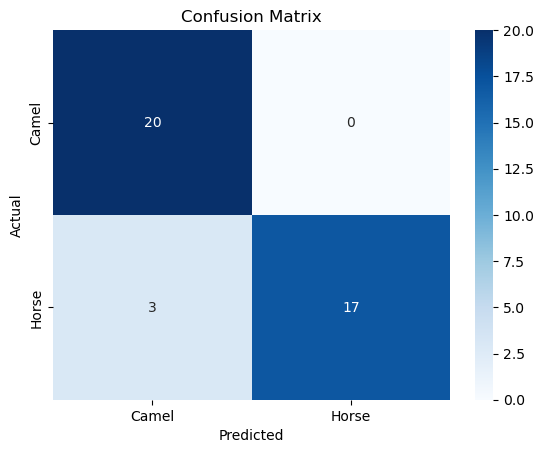


Classification Report:
               precision    recall  f1-score   support

       Camel       0.87      1.00      0.93        20
       Horse       1.00      0.85      0.92        20

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40



In [84]:
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Camel', 'Horse'], yticklabels=['Camel', 'Horse'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=['Camel', 'Horse']))

### Summary:
- After several attempts with different number of unfreezed layers and number of epochs, I ended up with the following configuration:
    - Unfreezed the last 25 layers
    - Epochs: 15
    - Learning rate: 1e-5

- It obtained an accuracy of 0.9500 and a loss of 0.2286 on the test dataset.
- The confusion matrix shows that the model performs pretty well on the test dataset, with only 3 misclassified images out of 40 (3 camels were misclassified as horses).